In [1]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from utils.visualization_utils import get_dict

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [126]:
#vrd_train_annotations = json.load(open("/data/ranjaykrishna/ReferringRelationships/data/VRD/annotations_train.json"))
#vrd_test_annotations = json.load(open("/data/ranjaykrishna/ReferringRelationships/data/VRD/annotations_test.json"))
#clevr_test_annotations = json.load(open("/data/ranjaykrishna/ReferringRelationships/data/clevr_color/annotations_test.json"))
#vg_train_annotations = json.load(open("/data/ranjaykrishna/ReferringRelationships/data/VisualGenome/VisualGenome/annotations_train.json"))
vg_test_annotations = json.load(open("/data/chami/ReferringRelationships/data/VisualGenome/annotations_test.json"))

In [127]:
vrd_obj_cat = json.load(open("/data/ranjaykrishna/ReferringRelationships/data/VRD/objects.json"))
#clevr_obj_cat = json.load(open("/data/ranjaykrishna/ReferringRelationships/data/clevr_color/cat2obj.json"))

In [128]:
def update_dict(dic, k, v):
    if k in dic:
        if not v in dic[k]:
            dic[k] += [v]
    else:
        dic[k] = [v]
    return dic

def get_stats(annotations, data):
    images_list = []
    nb_im = 0
    nb_im_multiple_objects = 0
    for img in annotations:
        nb_im += 1
        objects_dict = {}
        for rel in annotations[img]:
            s_bbox = rel["subject"]["bbox"]
            o_bbox = rel["object"]["bbox"]
            s_cat = rel["subject"]["category"]
            o_cat = rel["object"]["category"]
            s_center = (int((s_bbox[0] + s_bbox[1])/2), int((s_bbox[2] + s_bbox[3])/2))
            o_center = (int((o_bbox[0] + o_bbox[1])/2), int((o_bbox[2] + o_bbox[3])/2))
            objects_dict = update_dict(objects_dict, s_cat, s_center)
            objects_dict = update_dict(objects_dict, o_cat, o_center)
        if len(objects_dict) < sum([len(x) for x in objects_dict.values()]):
            nb_im_multiple_objects += 1
            images_list += [img]
    print("Proportion of images with same object category appearing multiple times")
    print("{} : {}".format(data, 1.*nb_im_multiple_objects/nb_im))
    return images_list

def get_rel_multiple_objects(annotations, data):
    filtered_annotations = {}
    nb_rels = 0
    nb_rel_multiple_objects = 0
    for img in annotations:
        for rel in annotations[img]:
            nb_rels += 1
            s_bbox = rel["subject"]["bbox"]
            o_bbox = rel["object"]["bbox"]
            s_cat = rel["subject"]["category"]
            o_cat = rel["object"]["category"]
            s_center = (int((s_bbox[0] + s_bbox[1])/2), int((s_bbox[2] + s_bbox[3])/2))
            o_center = (int((o_bbox[0] + o_bbox[1])/2), int((o_bbox[2] + o_bbox[3])/2))
            if s_cat == o_cat:
                nb_rel_multiple_objects += 1
                if img in filtered_annotations:
                    filtered_annotations[img] += [rel]
                else:
                    filtered_annotations[img] = [rel]
    print("Proportion of relations with same object and subject category")
    print("{} : {}".format(data, 1.*nb_rel_multiple_objects/nb_rels))
    print("Total number of relationships: {}".format(nb_rels))
    return filtered_annotations

def get_annotation_obj_list(annotations, obj_list, data):
    filtered_annotations = {}
    nb_rels = 0
    nb_rel_in_cat = 0
    for img in annotations:
        for rel in annotations[img]:
            nb_rels += 1
            s_cat = vrd_obj_cat[rel["subject"]["category"]]
            o_cat = vrd_obj_cat[rel["object"]["category"]]
            if s_cat in obj_list or o_cat in obj_list:
                nb_rel_in_cat += 1
                if img in filtered_annotations:
                    filtered_annotations[img] += [rel]
                else:
                    filtered_annotations[img] = [rel]
    print("Proportion of relations with object or subject category in:\n {}".format(obj_list))
    print("{} : {}".format(data, 1.*nb_rel_in_cat/nb_rels))
    print("Total number of relationships: {}".format(nb_rels))
    print("Number of relationships kept: {}".format(nb_rel_in_cat))
    return filtered_annotations

In [129]:
def get_rel_subset(annotations, data):
    filtered_annotations = {}
    nb_rel = 0
    nb_im_multiple_objects = 0
    for img in list(annotations.keys()):
        objects_list = {}
        for rel in annotations[img]:
            nb_rel += 1
            s_bbox = rel["subject"]["bbox"]
            o_bbox = rel["object"]["bbox"]
            s_cat = rel["subject"]["category"]
            o_cat = rel["object"]["category"]
            s_center = (int((s_bbox[0] + s_bbox[1])/2), int((s_bbox[2] + s_bbox[3])/2))
            o_center = (int((o_bbox[0] + o_bbox[1])/2), int((o_bbox[2] + o_bbox[3])/2))
            objects_list = update_dict(objects_list, s_cat, s_center)
            objects_list = update_dict(objects_list, o_cat, o_center)
        multiple_objects = []
        for x in objects_list:
            if len(objects_list[x]) > 1:
                for center in objects_list[x]:
                    multiple_objects += [(x, center)]
        for rel in annotations[img]:
            s_bbox = rel["subject"]["bbox"]
            o_bbox = rel["object"]["bbox"]
            s_cat = rel["subject"]["category"]
            o_cat = rel["object"]["category"]
            s_center = (int((s_bbox[0] + s_bbox[1])/2), int((s_bbox[2] + s_bbox[3])/2))
            o_center = (int((o_bbox[0] + o_bbox[1])/2), int((o_bbox[2] + o_bbox[3])/2))
            if (s_cat, s_center) in multiple_objects or (o_cat, o_center) in multiple_objects:
                nb_im_multiple_objects += 1
                filtered_annotations = update_dict(filtered_annotations, img, rel)
    print("Proportion of relationships with object category appearing multiple times")
    print("{} : {}".format(data, 1.*nb_im_multiple_objects/nb_rel))
    return filtered_annotations

In [130]:
def area(bbox):
    return (bbox[1]-bbox[0])*(bbox[3]-bbox[2])

def compute_iou(bb1, bb2):
    horiz_int = max(0, min(bb1[3], bb2[3]) - max(bb1[2], bb2[2]))
    vert_int = max(0, min(bb1[1], bb2[1]) - max(bb1[0], bb2[0]))
    intersection = horiz_int*vert_int
    return intersection*1./(area(bb1) + area(bb2) - intersection)

def get_max_iou(bboxes, bbox):
    max_iou = -1
    best_bbox = None
    for candidate_bbox in bboxes:
        iou = compute_iou(candidate_bbox, bbox)
        if iou > max_iou:
            max_iou = iou
            best_bbox = candidate_bbox
    return max_iou, best_bbox

def merge_bboxes(rels, inst_type, thresh=0.8):
    cat_dict = {}
    merged_rels = []
    for rel in rels:
        cat = rel[inst_type]["category"]
        bbox = rel[inst_type]["bbox"]
        if cat in cat_dict:
            max_iou, bbox_match = get_max_iou(cat_dict[cat], bbox)
            if max_iou > thresh:
                rel[inst_type]["bbox"] = bbox_match
            else:
                cat_dict[cat] += [bbox]
        else:
            cat_dict[cat] = [bbox]
        merged_rels += [rel]
    return merged_rels

def get_rel_subset(annotations, data, inst_type):
    filtered_annotations = {}
    nb_rel = 0
    nb_im_multiple_objects = 0
    for img in list(annotations.keys()):
        annotations[img] = merge_bboxes(annotations[img], inst_type)
        objects_list = {}
        for rel in annotations[img]:
            nb_rel += 1
            bbox = rel[inst_type]["bbox"]
            cat = rel[inst_type]["category"]
            center = (int((bbox[0] + bbox[1])/2), int((bbox[2] + bbox[3])/2))
            objects_list = update_dict(objects_list, cat, center)
        multiple_objects = []
        for x in objects_list:
            if len(objects_list[x]) > 1:
                for center in objects_list[x]:
                    multiple_objects += [(x, center)]
        for rel in annotations[img]:
            bbox = rel[inst_type]["bbox"]
            cat = rel[inst_type]["category"]
            center = (int((bbox[0] + bbox[1])/2), int((bbox[2] + bbox[3])/2))
            if (cat, center) in multiple_objects:
                nb_im_multiple_objects += 1
                filtered_annotations = update_dict(filtered_annotations, img, rel)
    print("Proportion of relationships with {} category appearing multiple times for {}".format(inst_type, data))
    print("{} % of {} relationships in total".format(np.round(1.*nb_im_multiple_objects/nb_rel, 2), nb_rel))
    return filtered_annotations

In [123]:
vg_test_annotations = json.load(open("/data/chami/ReferringRelationships/data/VisualGenome/annotations_test.json"))
filtered_subj_annotations = get_rel_subset(vg_test_annotations, "vg", "subject")

Proportion of relationships with subject category appearing multiple times for vrd
0.39 % of 7638 relationships in total


In [124]:
filtered_obj_annotations = get_rel_subset(vrd_test_annotations, "vg", "object")

Proportion of relationships with object category appearing multiple times for vrd
0.26 % of 7638 relationships in total


In [125]:
json.dump(filtered_subj_annotations, open('/data/chami/ReferringRelationships/data/VRD/vrd_test_annotations_multiple_subjects.json', 'w'))
json.dump(filtered_obj_annotations, open('/data/chami/ReferringRelationships/data/VRD/vrd_test_annotations_multiple_objects.json', 'w'))

sky
person
helmet
shirt
helmet
person
person
shirt
helmet
sky
sky


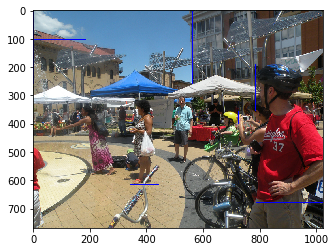

In [120]:
from PIL import Image, ImageDraw
im_id = np.random.choice(list(filtered_obj_annotations.keys()))
im = Image.open('/data/chami/VRD/sg_dataset/sg_test_images/' + im_id)
draw = ImageDraw.Draw(im)
for x in filtered_obj_annotations[im_id]:
    print(vrd_obj_cat[x["object"]["category"]])
    y_min, y_max, x_min, x_max = x['object']['bbox']
    draw.rectangle([x_min, y_min, x_max, y_max], outline="blue")
plt.imshow(im)

In [121]:
[x["object"] for x in filtered_obj_annotations[im_id]]

[{'bbox': [3, 259, 1, 563], 'category': 1},
 {'bbox': [310, 614, 343, 444], 'category': 0},
 {'bbox': [190, 356, 785, 954], 'category': 36},
 {'bbox': [330, 678, 786, 1024], 'category': 6},
 {'bbox': [190, 356, 785, 954], 'category': 36},
 {'bbox': [310, 614, 343, 444], 'category': 0},
 {'bbox': [348, 591, 631, 742], 'category': 0},
 {'bbox': [338, 432, 494, 565], 'category': 6},
 {'bbox': [356, 401, 663, 725], 'category': 36},
 {'bbox': [3, 103, 1, 186], 'category': 1},
 {'bbox': [3, 259, 1, 563], 'category': 1}]

In [50]:
filtered_annotations = get_rel_subset(vrd_test_annotations, "vrd")

Proportion of relationships with object category appearing multiple times
vrd : 0.5806493846556691


In [53]:
json.dump(filtered_annotations, open('/data/chami/ReferringRelationships/data/VRD/annotations_test_multi.json', 'w'))

In [52]:
len(vrd_test_annotations)

1000

In [45]:
len(clevr_test_annotations)

15000

In [41]:
filtered_annotations['10008170616_a54deca9e3_b.jpg']

[{'object': {'bbox': [176, 265, 4, 102], 'category': 10},
  'predicate': 1,
  'subject': {'bbox': [101, 601, 1, 110], 'category': 0}},
 {'object': {'bbox': [293, 591, 2, 68], 'category': 6},
  'predicate': 1,
  'subject': {'bbox': [101, 601, 1, 110], 'category': 0}},
 {'object': {'bbox': [389, 435, 721, 747], 'category': 52},
  'predicate': 27,
  'subject': {'bbox': [241, 550, 707, 846], 'category': 0}},
 {'object': {'bbox': [320, 361, 953, 1021], 'category': 62},
  'predicate': 2,
  'subject': {'bbox': [267, 675, 865, 1024], 'category': 0}},
 {'object': {'bbox': [267, 675, 865, 1024], 'category': 0},
  'predicate': 0,
  'subject': {'bbox': [320, 361, 953, 1021], 'category': 62}},
 {'object': {'bbox': [267, 675, 865, 1024], 'category': 0},
  'predicate': 0,
  'subject': {'bbox': [492, 554, 960, 996], 'category': 95}}]

In [14]:
obj_list = ["hydant", "faucet", "luggage", "suitcase", "ramp", "grass", "sky"]
filtered_annotations = get_annotation_obj_list(vrd_test_annotations, obj_list, "vrd")

Proportion of relations with object or subject category in:
 ['hydant', 'faucet', 'luggage', 'suitcase', 'ramp', 'grass', 'sky']
vrd : 0.11861743912018853
Total number of relationships: 7638
Number of relationships kept: 906


In [25]:
json.dump(ann, open('/data/chami/ReferringRelationships/data/vrd_rels_multiple_objects.json', 'w'))

In [8]:
test_vrd_images = get_stats(vrd_test_annotations, "vrd")

Proportion of images with same object category appearing multiple times
vrd : 0.612


In [106]:
len(test_vg_images)

5160

In [102]:
json.dump(test_vrd_images, open('/data/chami/ReferringRelationships/data/vrd_images_multiple_objects.json', 'w'))

In [109]:
json.dump(test_vg_images, open('/data/chami/ReferringRelationships/data/visual_genome_images_multiple_objects.json', 'w'))